Modified Python version of Cara's 2024 R script attached as the .rmd file

# Ratios

## Import and Clean Data

In [89]:
# # I use the anaconda prompt with my Universal_EEG_Analyzer
# # conda activate Universal_EEG_Analyzer
# # pip install ...
# # Here is code to find location of kernel
# import sys
# print(sys.executable)

In [90]:
# Libraries
import pandas as pd
import scipy.stats as stats
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
# Load the dataset
file_path = "C:/Users/Jalynn/OneDrive/Documents/GitHub/Universal_EEG_Analyzer/StudyTwoGermaneLoadAnalysis/GammaResults2/All_Ratios_Summary.csv"
df = pd.read_csv(file_path)

In [92]:
# Added for testing with ptps not completely finished
data_cols = [col for col in df.columns if col != 'PIDPhase']
df = df.dropna(subset=data_cols, how='all')

# Split PXX_phase into PXX and phase columns
df[['PID', 'Phase']] = df['PIDPhase'].astype(str).str.extract(r'P(\d+)_([A-Za-z]+)')
df = df.drop(columns=['PIDPhase'])

# Ensure condition is a factor in R/category in Python
df['Condition'] = df['Phase'].astype('category')

# Reset the index
df = df.reset_index(drop=True)
print(df)

    LowGermane_ratio1  LowGermane_ratio2  HighGermane_ratio1  \
0            0.261785           0.097010            0.287086   
1            0.283345           0.077160            0.250629   
2            0.257052           0.065430            0.266024   
3            0.287995           0.092861            0.530054   
4            0.289758           0.086993            0.293747   
5            0.265653           0.085028            0.314447   
6            0.294471           0.082769            0.305896   
7            0.251311           0.083555            0.284458   
8            0.316852           0.100841            0.412281   
9            0.183637           0.061536            0.192323   
10           0.303056           0.080033            0.258338   
11           0.247184           0.081636            0.301587   
12           0.226121           0.085101            0.289038   
13           0.243579           0.074527            0.293721   
14           0.226290           0.070257

## Is my data normally distributed?

In [93]:
# Shapiro-Wilk Text
# Basically a t-test
shapiro_stat, shapiro_p = stats.shapiro(df['HighGermane_ratio2'].dropna())
print(f"--- Shapiro-Wilk Test for LowGermane_ratio1 ---")
print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p}\n")

--- Shapiro-Wilk Test for LowGermane_ratio1 ---
Statistic: 0.8472, p-value: 1.2978326922715355e-05



## Ratios within conditions

In [94]:
# R: wilcox.test(Cond1_ratio1 ~ Phase, data = df)
# This is a Mann-Whitney U test (independent) comparing values between the groups in 'Phase'.
# Get the two groups from the 'Phase' column (e.g., 'Train' and 'Test')
# We must split the dataframe to compare the groups
phases = df['Phase'].unique()
if len(phases) == 2:
    group1_data = df[df['Phase'] == phases[0]]
    group2_data = df[df['Phase'] == phases[1]]
    
    ratios_to_test = [
        "LowGermane_ratio1", "LowGermane_ratio2", "HighGermane_ratio1", "HighGermane_ratio2"
    ]

    for ratio in ratios_to_test:
        # Get the two vectors to compare, dropping NaNs
        x = group1_data[ratio].dropna()
        y = group2_data[ratio].dropna()
        
        # Run the MWU test and get effect size using pingouin in one line
        # Equivalent to the R cliff.delta lines
        mwu_results = pg.mwu(x, y, alternative='two-sided')
        
        # Extract the values from the resulting DataFrame
        mwu_stat = mwu_results['U-val'].iloc[0]
        mwu_p = mwu_results['p-val'].iloc[0]
        cles = mwu_results['CLES'].iloc[0] # Common Language Effect Size (similar to Cliff's)

        print(f"\n{ratio} (by Phase: {phases[0]} vs {phases[1]}):")
        print(f"  MWU Statistic: {mwu_stat:.4f}, p-value: {mwu_p:.4f}")
        # CLES is the probability that a random pick from one group
        # will be higher than a random pick from the other.
        print(f"  Common Language Effect Size (CLES): {cles:.4f}")
else:
    print(f"Warning: 'Phase' column has {len(phases)} groups. MWU test is for 2 groups.")


LowGermane_ratio1 (by Phase: train vs test):
  MWU Statistic: 264.0000, p-value: 0.3517
  Common Language Effect Size (CLES): 0.4224

LowGermane_ratio2 (by Phase: train vs test):
  MWU Statistic: 244.0000, p-value: 0.1870
  Common Language Effect Size (CLES): 0.3904

HighGermane_ratio1 (by Phase: train vs test):
  MWU Statistic: 320.0000, p-value: 0.8920
  Common Language Effect Size (CLES): 0.5120

HighGermane_ratio2 (by Phase: train vs test):
  MWU Statistic: 342.0000, p-value: 0.5737
  Common Language Effect Size (CLES): 0.5472


Shapiro-Wilk Test Key finding: My p-value is always extremely close to zero. I cannot use a t-test since my data is not normally distributed.

Mann-Whitney U test Key finding: When comparing the train phase to the test phase, there is no significant differences found.

## Ratios between conditions

In [95]:
print("\n--- Ratios Between Conditions (Paired Wilcoxon Test) ---")

# We loop through each Phase ('train' and 'test')
for phase in df['Phase'].unique():
    print(f"\n--- Analyzing Phase: {phase.upper()} ---")
    
    # Filter the DataFrame for the current phase
    df_phase = df[df['Phase'] == phase]
    
    # --- Test 1: ratio1 (Low vs High) ---
    
    # First, we must dropna() on BOTH columns together to keep the pairs
    data_paired_r1 = df_phase[['LowGermane_ratio1', 'HighGermane_ratio1']].dropna()
    
    # Run the paired Wilcoxon test
    paired_test_r1 = pg.wilcoxon(data_paired_r1['LowGermane_ratio1'], 
                                 data_paired_r1['HighGermane_ratio1'], 
                                 alternative='two-sided')
    
    print("\nTest: LowGermane_ratio1 vs. HighGermane_ratio1")
    print(paired_test_r1)
    
    # --- Test 2: ratio2 (Low vs High) ---
    
    # Repeat for ratio2
    data_paired_r2 = df_phase[['LowGermane_ratio2', 'HighGermane_ratio2']].dropna()
    
    paired_test_r2 = pg.wilcoxon(data_paired_r2['LowGermane_ratio2'], 
                                 data_paired_r2['HighGermane_ratio2'], 
                                 alternative='two-sided')
    
    print("\nTest: LowGermane_ratio2 vs. HighGermane_ratio2")
    print(paired_test_r2)


--- Ratios Between Conditions (Paired Wilcoxon Test) ---

--- Analyzing Phase: TRAIN ---

Test: LowGermane_ratio1 vs. HighGermane_ratio1
          W-val alternative     p-val       RBC    CLES
Wilcoxon   41.0   two-sided  0.000556 -0.747692  0.2944

Test: LowGermane_ratio2 vs. HighGermane_ratio2
          W-val alternative     p-val       RBC   CLES
Wilcoxon   80.0   two-sided  0.025505 -0.507692  0.416

--- Analyzing Phase: TEST ---

Test: LowGermane_ratio1 vs. HighGermane_ratio1
          W-val alternative     p-val       RBC    CLES
Wilcoxon  152.0   two-sided  0.791476  0.064615  0.4736

Test: LowGermane_ratio2 vs. HighGermane_ratio2
          W-val alternative     p-val       RBC    CLES
Wilcoxon  113.0   two-sided  0.190814  0.304615  0.5856



--- Generating Boxplot ---


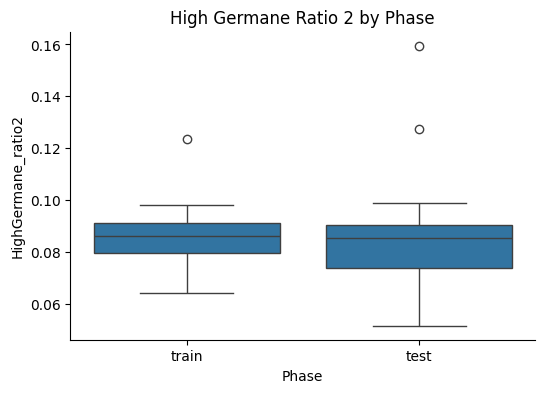

In [96]:
print("\n--- Generating Boxplot ---")

plt.figure(figsize=(6, 4)) # Set figure size
# R: aes(x = Phase, y = Cond2_ratio2)
# Py: x='Phase', y='HighGermane_ratio2'
sns.boxplot(data=df, x='Phase', y='HighGermane_ratio2')

plt.title('High Germane Ratio 2 by Phase') # Add a title
sns.despine() # This is similar to theme_minimal()
plt.show() # Display the plot

Between Conditions Key Findings: statistical significance between low and high loads during the training. This difference disappears in the test phase

# High Level Overview:  
* Used Shapiro-Wilk test to confirm my data is not normally distributed (low p-value)
* Used Wilcoxon, non-parametric tests, instead of t-test
* Used Mann-Whitney U to compare train vs. test (within conditions) and found no significant difference
* Used Paired Wilcoxon to compare low vs. high and found a significant difference in the train phase that disappears in the test phase

# Visualize Ratios  
Left off on line 82 in R code

# Repeat for Gamma

# Correlate with Behavior